## Evaluating Topic Model Coherence

In this notebook, we will evaluate the coherence of our topic model. Coherence measures how well the words in a topic make sense together to human readers. We will use the Normalized Pointwise Mutual Information (NPMI) to calculate coherence.

PS: to run the code below, you would need to have saved one or more models. To do so, you can run the notebook `02_model_training.ipynb` that creates a model in the `models` folder or to create multiple models by using the python command `python src/topic_modeller.py -c configs/model_configs.jsonl`. You would also need to have run the notebook `01_data_preparation.ipynb`, which saves in the `data` folder a `doc_term_matrix.pkl`.

In [6]:
import pickle
from pathlib import Path
from src.metrics_utils import Coherence
from src.topic_utils import TopicAnalyser
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load all models from the models folder
model_folder = Path('./models')
model_files = model_folder.glob('*.pkl')
all_models = {}
for model_file in model_files:
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
        all_models[model_file.stem] = model

### Load Document-Term Matrix and Vocabulary

Next, we will load the document-term matrix and vocabulary from the `data` folder.

In [8]:
# Load document-term matrix and vocabulary
data_folder = Path('./data')
with open(data_folder / 'doc_term_matrix.pkl', 'rb') as f:
    X = pickle.load(f)
with open(data_folder / 'vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

### Calculate Coherence

We will now calculate the coherence of each topic model using the NPMI metric. Higher coherence scores indicate more meaningful topics.

In [9]:
# Coherence assesses how well the words in a topic make sense together to human readers. 
# It requires a matrix of word co-occurrence X to compute p(w_i) and p(w_i,w_j)
# Coherence implements the average NPMI that goes from -1 to 1. The larger, the more coherent.

coherence = Coherence(X)
model_coherence = {}
for model_name, topic_model in all_models.items():
    topics = topic_model.topic_word_
    topic_mixtures = topic_model.doc_topic_
    topic_analyser = TopicAnalyser(topic_mixtures, topics, vocab, ntop=5)
    top_token_indexes = topic_analyser.get_all_top_word_index()
    r_coherence = coherence.model_coherence(top_token_indexes)
    model_coherence[model_name] = {
        'metrics': {
            'mean': round(float(np.mean(r_coherence)), 2),
            'min': round(float(np.min(r_coherence)), 2),
            'max': round(float(np.max(r_coherence)), 2),
            'median': round(float(np.median(r_coherence)), 2)
        },
        'scores': r_coherence
    }

### Display Results

Finally, we will display the coherence scores for each topic model and suggest which model is better based on the highest coherence score.

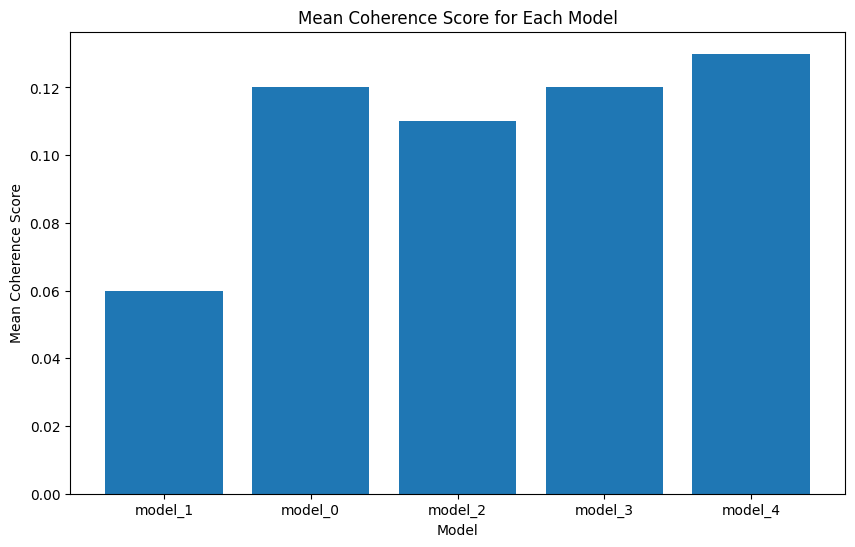

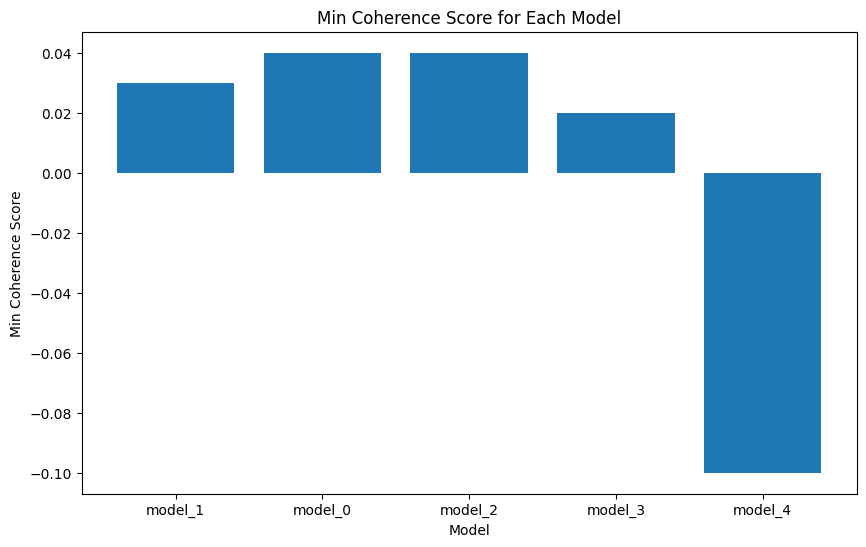

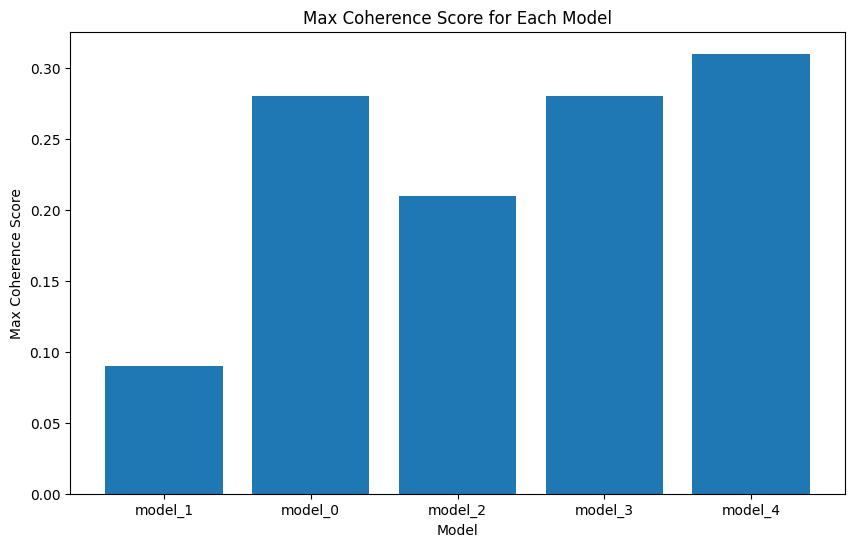

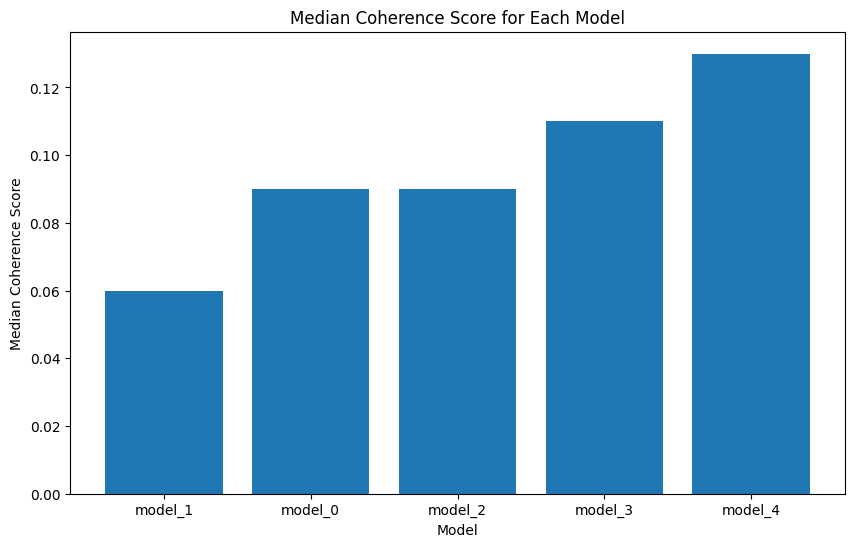

The model with the highest mean coherence score is: model_4


In [10]:
# Plot the metrics of the models
metrics = ['mean', 'min', 'max', 'median']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(model_coherence.keys(), [model_coherence[model]['metrics'][metric] for model in model_coherence])
    plt.xlabel('Model')
    plt.ylabel(f'{metric.capitalize()} Coherence Score')
    plt.title(f'{metric.capitalize()} Coherence Score for Each Model')
    plt.show()

# Print the model with the highest mean coherence score
best_model = max(model_coherence, key=lambda k: model_coherence[k]['metrics']['mean'])
print(f'The model with the highest mean coherence score is: {best_model}')


### Plot Coherence Scores

Plotting the coherence scores for each topic helps us visually if there are out standingtopics with low coherence (negative score) This can make it easier to identify if the model has too many incoherent topics

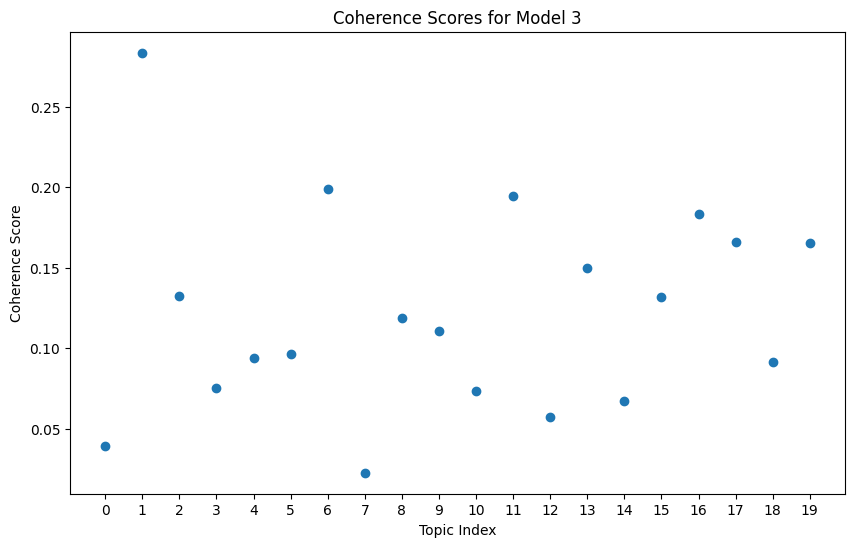

In [11]:
coherence_scores = model_coherence['model_3']['scores']
x_values = [str(i) for i in range(len(coherence_scores))]
plt.figure(figsize=(10, 6))
plt.scatter(x_values, coherence_scores, marker='o')
plt.xlabel('Topic Index')
plt.ylabel('Coherence Score')
plt.title('Coherence Scores for Model 3')
plt.show()


### Suggest Best Model

Based on the coherence scores, we suggest the model with the highest mean coherence score as the better model.

In [12]:
best_model = max(model_coherence, key=lambda k: model_coherence[k]['metrics']['mean'])
best_model

'model_4'

### Plot Coherence Scores for Each Topic

Plotting the coherence scores for each topic helps us visually identify if there are outstanding topics with low coherence (negative score). This can make it easier to identify if the model has too many incoherent topics.

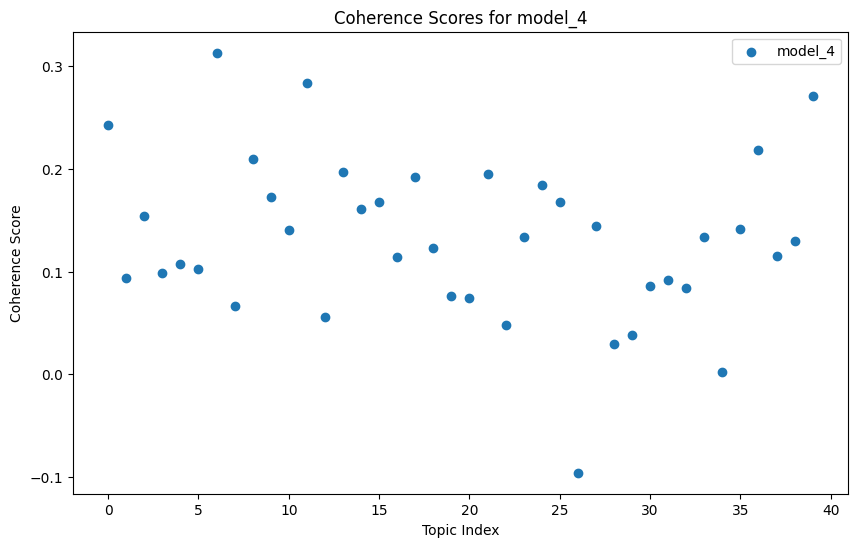

In [13]:
# Plot coherence scores for each topic
model_name = best_model
data =  model_coherence[model_name]
plt.figure(figsize=(10, 6))
plt.scatter(range(len(data['scores'])), data['scores'], label=model_name)
plt.xlabel('Topic Index')
plt.ylabel('Coherence Score')
plt.title(f'Coherence Scores for {model_name}')
plt.legend()
plt.show()